In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import tensorflow as tf
import h5py
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

2023-12-04 23:16:19.861025: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Define models

clean_test_data = r'test.h5'
poisoned_test_data = r'bd_test.h5'
clean_val_data = r'valid.h5'
poisoned_val_data = r'bd_valid.h5'
badnet_model = r'bd_net.h5'

In [3]:
# Define GoodNet Class

class G(tf.keras.Model):
    def __init__(self, B_path, B_prime_path):
        super(G, self).__init__()
        self.B = tf.keras.models.load_model(B_path)
        self.B_prime = tf.keras.models.load_model(B_prime_path)
        self.backdoor_class_index = self.B.layers[-1].output_shape[-1]

    def predict(self, data):
        y = np.argmax(self.B.predict(data), axis=1)
        y_prime = np.argmax(self.B_prime.predict(data), axis=1)
        pred = np.zeros(data.shape[0])
        for i in range(data.shape[0]):
            if y[i] == y_prime[i]:
                pred[i] = y[i]
            else:
                pred[i] = self.backdoor_class_index
        return pred

In [4]:
# Model Evaluation Function

def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))
    return x_data, y_data

def evaluate_model(clean_data_filename, poisoned_data_filename, model_input):
    cl_x_test, cl_y_test = data_loader(clean_data_filename)
    bd_x_test, bd_y_test = data_loader(poisoned_data_filename)

    # Determine the type of model_input and load or use the model accordingly
    if isinstance(model_input, str):
        model = tf.keras.models.load_model(model_input)
        predict_function = lambda x: np.argmax(model.predict(x), axis=1)
    elif isinstance(model_input, G):
        model = model_input
        predict_function = lambda x: model.predict(x)
    else:  # Assuming model_input is a Keras model
        model = model_input
        predict_function = lambda x: np.argmax(model.predict(x), axis=1)

    # Evaluate the model
    cl_label_prd = predict_function(cl_x_test)
    cl_clf_acc = np.mean(np.equal(cl_label_prd, cl_y_test)) * 100
    print('Classification Accuracy on Clean Data:', cl_clf_acc)

    bd_label_prd = predict_function(bd_x_test)
    at_suc_rt = np.mean(np.equal(bd_label_prd, bd_y_test)) * 100
    print('Attack Success Rate using Poisoned Data:', at_suc_rt)

    return cl_clf_acc, at_suc_rt

In [5]:
# Get baseline stats for model

bl_cl_clf_acc, bl_at_suc_rt = evaluate_model(clean_val_data, poisoned_val_data, badnet_model)

361/361 [==============================] - 2s 5ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


In [6]:
# Visualize the Model Structure

model = tf.keras.models.load_model(badnet_model)
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 55, 47, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 52, 44, 20)           980       ['input[0][0]']               
                                                                                                  
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 24, 20, 40)           7240      ['pool_1[0][0]']              
                                                                                            

In [7]:
# Clear the current Tensorflow Keras session

tf.keras.backend.clear_session()

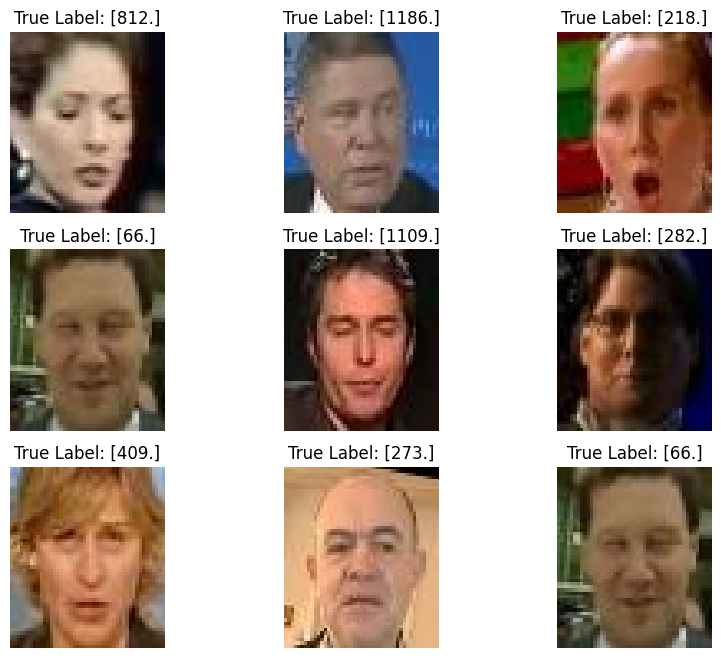

In [8]:
# Visualize the clean data

x_data, y_data = data_loader(clean_val_data)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3

for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

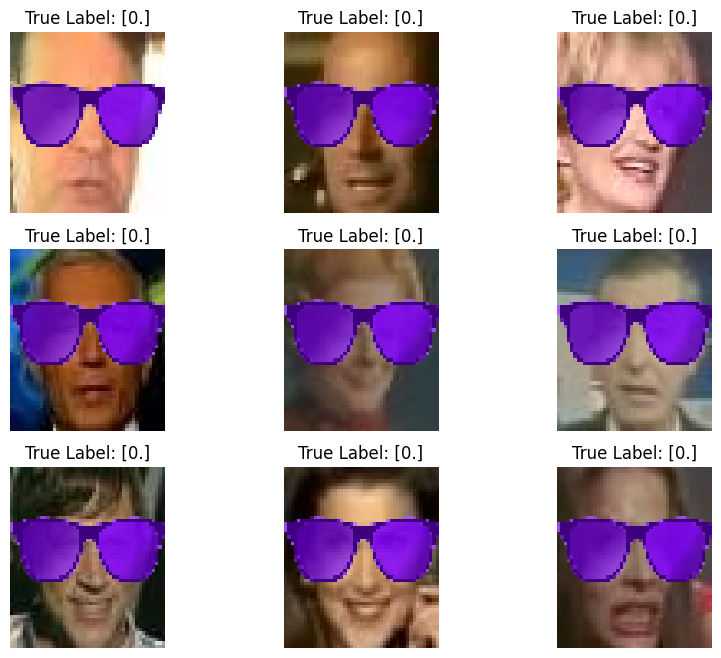

In [9]:
# Visualize the poisoned data

x_data, y_data = data_loader(poisoned_val_data)
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3

for i in range(1, cols*rows+1):
  index = np.random.randint(x_data.shape[0], size=1)
  img, label = (x_data[index], y_data[index])
  figure.add_subplot(rows, cols, i)
  plt.title("True Label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

In [10]:
# Create a copy of the BadNet model

model = tf.keras.models.load_model(badnet_model)
source_optimizer = model.optimizer
source_loss = model.loss
source_metrics = model.metrics
bd_model_cpy = tf.keras.models.clone_model(model)
bd_model_cpy.set_weights(model.get_weights())

In [11]:
# Pruning models as a defence against poisoned model

cl_clf_acc_arr = []
at_suc_rt_arr = []
saved_model = np.zeros(3,dtype=bool)

output_layer = bd_model_cpy.get_layer('pool_3').output
seq = np.argsort(np.mean(tf.keras.models.Model(inputs = bd_model_cpy.input, outputs = output_layer).predict(data_loader(clean_val_data)[0]), axis=(0,1,2)))
weight_0 = bd_model_cpy.layers[5].get_weights()[0]
bias_0 = bd_model_cpy.layers[5].get_weights()[1]

for channel_index in tqdm(seq):
    weight_0[:,:,:,channel_index] = 0
    bias_0[channel_index] = 0
    bd_model_cpy.layers[5].set_weights([weight_0, bias_0])
    cl_clf_acc, at_suc_rt = evaluate_model(clean_val_data, poisoned_val_data, bd_model_cpy)
    if (bl_cl_clf_acc - cl_clf_acc >= 2 and not saved_model[0]):
        print("Model Saved at 2% drop in classification accuracy.")
        bd_model_cpy.compile(optimizer=source_optimizer, 
                  loss=source_loss, 
                  metrics=source_metrics)
        bd_model_cpy.save('model_X_2.h5')
        saved_model[0] = 1
    if (bl_cl_clf_acc - cl_clf_acc >= 4 and not saved_model[1]):
        print("Model Saved at 4% drop in classification accuracy.")
        bd_model_cpy.compile(optimizer=source_optimizer, 
                  loss=source_loss, 
                  metrics=source_metrics)
        bd_model_cpy.save('model_X_4.h5')
        saved_model[1] = 1
    if (bl_cl_clf_acc - cl_clf_acc >= 10 and not saved_model[2]):
        print("Model Saved at 10% drop in classification accuracy.")
        bd_model_cpy.compile(optimizer=source_optimizer, 
                  loss=source_loss, 
                  metrics=source_metrics)
        bd_model_cpy.save('model_X_10.h5')
        saved_model[2] = 1
    cl_clf_acc_arr.append(cl_clf_acc)
    at_suc_rt_arr.append(at_suc_rt)
    tf.keras.backend.clear_session()

361/361 [==============================] - 2s 5ms/step


  0%|                                                                                              | 0/60 [00:00<?, ?it/s]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


  2%|█▍                                                                                    | 1/60 [00:08<08:07,  8.26s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


  3%|██▊                                                                                   | 2/60 [00:16<07:42,  7.98s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


  5%|████▎                                                                                 | 3/60 [00:23<07:31,  7.92s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


  7%|█████▋                                                                                | 4/60 [00:31<07:20,  7.86s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


  8%|███████▏                                                                              | 5/60 [00:39<07:13,  7.88s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 10%|████████▌                                                                             | 6/60 [00:47<07:03,  7.85s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 12%|██████████                                                                            | 7/60 [00:55<07:04,  8.00s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 13%|███████████▍                                                                          | 8/60 [01:04<07:04,  8.17s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 15%|████████████▉                                                                         | 9/60 [01:12<06:51,  8.06s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 17%|██████████████▏                                                                      | 10/60 [01:19<06:37,  7.96s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 18%|███████████████▌                                                                     | 11/60 [01:27<06:30,  7.97s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 20%|█████████████████                                                                    | 12/60 [01:35<06:19,  7.90s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 22%|██████████████████▍                                                                  | 13/60 [01:43<06:10,  7.88s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 23%|███████████████████▊                                                                 | 14/60 [01:51<06:04,  7.93s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 3s 7ms/step


 25%|█████████████████████▎                                                               | 15/60 [02:00<06:17,  8.39s/it]

Attack Success Rate using Poisoned Data: 100.0
361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 3s 7ms/step
Attack Success Rate using Poisoned Data: 100.0


 27%|██████████████████████▋                                                              | 16/60 [02:10<06:22,  8.70s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 28%|████████████████████████                                                             | 17/60 [02:18<06:08,  8.56s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 30%|█████████████████████████▌                                                           | 18/60 [02:26<05:50,  8.35s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 32%|██████████████████████████▉                                                          | 19/60 [02:34<05:35,  8.19s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 33%|████████████████████████████▎                                                        | 20/60 [02:43<05:36,  8.42s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 35%|█████████████████████████████▋                                                       | 21/60 [02:50<05:20,  8.22s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 37%|███████████████████████████████▏                                                     | 22/60 [02:59<05:14,  8.27s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 38%|████████████████████████████████▌                                                    | 23/60 [03:07<05:10,  8.40s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 40%|██████████████████████████████████                                                   | 24/60 [03:15<04:56,  8.24s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 42%|███████████████████████████████████▍                                                 | 25/60 [03:23<04:43,  8.10s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 43%|████████████████████████████████████▊                                                | 26/60 [03:32<04:40,  8.25s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 45%|██████████████████████████████████████▎                                              | 27/60 [03:40<04:29,  8.16s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 47%|███████████████████████████████████████▋                                             | 28/60 [03:48<04:24,  8.26s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 48%|█████████████████████████████████████████                                            | 29/60 [03:57<04:25,  8.57s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 50%|██████████████████████████████████████████▌                                          | 30/60 [04:05<04:11,  8.40s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 52%|███████████████████████████████████████████▉                                         | 31/60 [04:13<03:59,  8.27s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 53%|█████████████████████████████████████████████▎                                       | 32/60 [04:23<03:59,  8.57s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 55%|██████████████████████████████████████████████▊                                      | 33/60 [04:30<03:44,  8.31s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 98.64033948211657
361/361 [==============================] - 3s 7ms/step
Attack Success Rate using Poisoned Data: 100.0


 57%|████████████████████████████████████████████████▏                                    | 34/60 [04:39<03:41,  8.52s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 98.64033948211657
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 58%|█████████████████████████████████████████████████▌                                   | 35/60 [04:49<03:37,  8.72s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.63167922404088
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 60%|███████████████████████████████████████████████████                                  | 36/60 [04:57<03:26,  8.61s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.65765999826795
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 62%|████████████████████████████████████████████████████▍                                | 37/60 [05:05<03:15,  8.50s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 98.64899974019225
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 63%|█████████████████████████████████████████████████████▊                               | 38/60 [05:14<03:11,  8.69s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.6056984498138
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 65%|███████████████████████████████████████████████████████▎                             | 39/60 [05:22<02:57,  8.45s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 98.57105741751104
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 67%|████████████████████████████████████████████████████████▋                            | 40/60 [05:31<02:49,  8.48s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 98.53641638520828
361/361 [==============================] - 2s 7ms/step
Attack Success Rate using Poisoned Data: 100.0


 68%|██████████████████████████████████████████████████████████                           | 41/60 [05:40<02:45,  8.70s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 98.19000606218066
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 70%|███████████████████████████████████████████████████████████▍                         | 42/60 [05:48<02:34,  8.59s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 97.65307006148784
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 72%|████████████████████████████████████████████████████████████▉                        | 43/60 [05:58<02:31,  8.91s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 97.50584567420108
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 100.0


 73%|██████████████████████████████████████████████████████████████▎                      | 44/60 [06:08<02:26,  9.14s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 95.75647354291158
361/361 [==============================] - 2s 7ms/step
Attack Success Rate using Poisoned Data: 100.0


/Users/nicholasbennet/anaconda3/envs/jupyterlabml/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
 75%|███████████████████████████████████████████████████████████████▊                     | 45/60 [06:16<02:13,  8.93s/it]

Model Saved at 2% drop in classification accuracy.
361/361 [==============================] - 2s 5ms/step
Classification Accuracy on Clean Data: 95.20221702606739
361/361 [==============================] - 2s 6ms/step


 77%|█████████████████████████████████████████████████████████████████▏                   | 46/60 [06:24<02:02,  8.76s/it]

Attack Success Rate using Poisoned Data: 99.9913397419243
361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 94.7172425738287
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 99.9913397419243


 78%|██████████████████████████████████████████████████████████████████▌                  | 47/60 [06:33<01:51,  8.60s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 92.09318437689443
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 99.9913397419243
Model Saved at 4% drop in classification accuracy.

 80%|████████████████████████████████████████████████████████████████████                 | 48/60 [06:41<01:42,  8.57s/it]


361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 91.49562656967177
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 99.9913397419243


 82%|█████████████████████████████████████████████████████████████████████▍               | 49/60 [06:51<01:38,  8.96s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 91.01931237550879
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 99.98267948384861


 83%|██████████████████████████████████████████████████████████████████████▊              | 50/60 [06:59<01:26,  8.65s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 89.17467740538669
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 80.73958603966398


 85%|████████████████████████████████████████████████████████████████████████▎            | 51/60 [07:07<01:15,  8.44s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 84.43751623798389
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 77.015675067117


 87%|█████████████████████████████████████████████████████████████████████████▋           | 52/60 [07:16<01:09,  8.72s/it]

Model Saved at 10% drop in classification accuracy.
361/361 [==============================] - 2s 5ms/step
Classification Accuracy on Clean Data: 76.48739932449988
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 35.71490430414826


 88%|███████████████████████████████████████████████████████████████████████████          | 53/60 [07:24<00:59,  8.47s/it]

361/361 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 54.8627349095003
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 6.954187234779596


 90%|████████████████████████████████████████████████████████████████████████████▌        | 54/60 [07:33<00:51,  8.56s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 27.08928726076037
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 0.4243526457088421


 92%|█████████████████████████████████████████████████████████████████████████████▉       | 55/60 [07:43<00:44,  8.89s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 13.87373343725643
361/361 [==============================] - 3s 7ms/step
Attack Success Rate using Poisoned Data: 0.0


 93%|███████████████████████████████████████████████████████████████████████████████▎     | 56/60 [07:51<00:35,  8.80s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 7.101411622066338
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 0.0


 95%|████████████████████████████████████████████████████████████████████████████████▊    | 57/60 [08:01<00:27,  9.02s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 1.5501861955486274
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 0.0


 97%|██████████████████████████████████████████████████████████████████████████████████▏  | 58/60 [08:09<00:17,  8.86s/it]

361/361 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 0.7188014202823244
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 0.0


 98%|███████████████████████████████████████████████████████████████████████████████████▌ | 59/60 [08:18<00:08,  8.72s/it]

361/361 [==============================] - 2s 7ms/step
Classification Accuracy on Clean Data: 0.0779423226812159
361/361 [==============================] - 2s 6ms/step
Attack Success Rate using Poisoned Data: 0.0


100%|█████████████████████████████████████████████████████████████████████████████████████| 60/60 [08:27<00:00,  8.46s/it]


Text(0.5, 1.0, 'Classification Accuracy and Attack Success Rate for Validation Dataset')

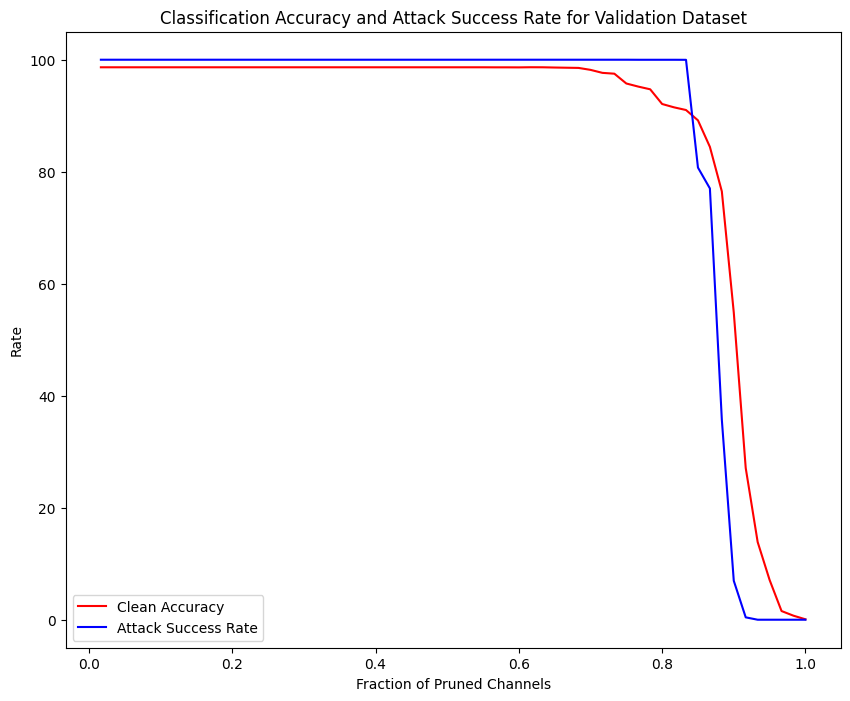

In [12]:
# Plot Pruning graph on validation data

figure = plt.figure(figsize=(10,8))
x_axis = np.arange(1,61)/60
plt.plot(x_axis, cl_clf_acc_arr, color='red')
plt.plot(x_axis, at_suc_rt_arr, color='blue')
plt.legend(['Clean Accuracy', 'Attack Success Rate'])
plt.xlabel("Fraction of Pruned Channels")
plt.ylabel("Rate")
plt.title("Classification Accuracy and Attack Success Rate for Validation Dataset")

In [13]:
# Clear the current Tensorflow Keras session

tf.keras.backend.clear_session()

In [14]:
# Define Pruned models

prune_model_X_2 = 'model_X_2.h5'
prune_model_X_4 = 'model_X_4.h5'
prune_model_X_10 = 'model_X_10.h5'

In [15]:
# Define GoodNet(Repaired) Models

G_model_X_2 = G(badnet_model, prune_model_X_2)
G_model_X_4 = G(badnet_model, prune_model_X_4)
G_model_X_10 = G(badnet_model, prune_model_X_10)

In [16]:
# Evaluate GoodNet(Repaired) Models
cl_clf_acc_X_2, at_suc_rt_X_2 = evaluate_model(clean_test_data, poisoned_test_data, G_model_X_2)
cl_clf_acc_X_4, at_suc_rt_X_4 = evaluate_model(clean_test_data, poisoned_test_data, G_model_X_4)
cl_clf_acc_X_10, at_suc_rt_X_10 = evaluate_model(clean_test_data, poisoned_test_data, G_model_X_10)

401/401 [==============================] - 3s 6ms/step
Classification Accuracy on Clean Data: 95.74434918160561
401/401 [==============================] - 3s 6ms/step
Attack Success Rate using Poisoned Data: 100.0
401/401 [==============================] - 2s 6ms/step
Classification Accuracy on Clean Data: 92.1278254091972
401/401 [==============================] - 3s 7ms/step
Attack Success Rate using Poisoned Data: 99.98441153546376
401/401 [==============================] - 3s 7ms/step
Classification Accuracy on Clean Data: 84.3335931410756
401/401 [==============================] - 3s 7ms/step
Attack Success Rate using Poisoned Data: 77.20966484801247


In [17]:
# Table of GoodNet(Repaired) model evaluation

cl_clf_acc_tb = [cl_clf_acc_X_2, cl_clf_acc_X_4, cl_clf_acc_X_10]
at_suc_rt_tb = [at_suc_rt_X_2, at_suc_rt_X_4, at_suc_rt_X_10]
data = {
    "Classification Accuracy on Clean Data": cl_clf_acc_tb,
    "Attack Success Rate using Poisoned Data": at_suc_rt_tb,
    "Model": ["GoodNet_2%", "GoodNet_4%", "GoodNet_10%"]
}
df = pd.DataFrame(data)
df.set_index('Model')

,Classification Accuracy on Clean Data,Attack Success Rate using Poisoned Data
Model,,
GoodNet_2%,95.744349,100.000000
GoodNet_4%,92.127825,99.984412
GoodNet_10%,84.333593,77.209665


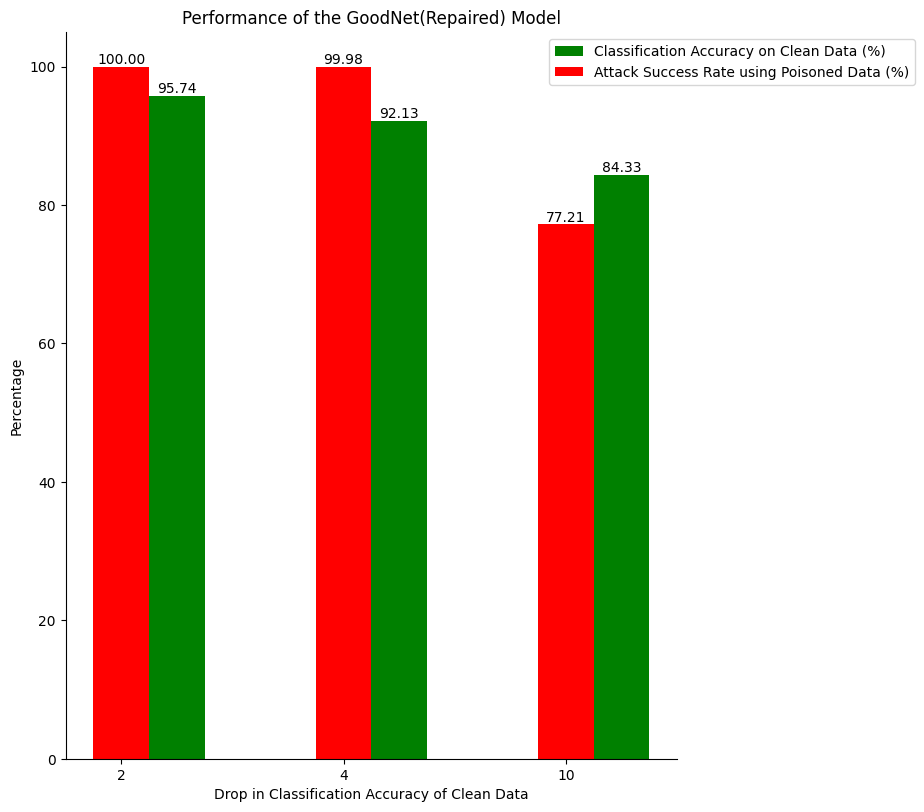

In [18]:
# Graph of GoodNet(Repaired) model evaluation

opacity = 1
bar_width = 0.25

figure = plt.figure(figsize=(10,8))
plt.xlabel('Drop in Classification Accuracy of Clean Data')
plt.ylabel('Percentage')

plt.xticks(range(len(cl_clf_acc_tb)),('2', '4', '10'))
bar1 = plt.bar(np.arange(len(cl_clf_acc_tb)) + bar_width, cl_clf_acc_tb, bar_width, align='center', alpha=opacity, color='green', label='Classification Accuracy on Clean Data (%)')
bar2 = plt.bar(range(len(at_suc_rt_tb)),at_suc_rt_tb, bar_width, align='center', alpha=opacity, color='red', label='Attack Success Rate using Poisoned Data (%)')

for rect in bar1 + bar2:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width() / 2.0, height, f'{height:.02f}', ha='center', va='bottom')

plt.legend(bbox_to_anchor=(1.4, 1))
plt.tight_layout()
plt.title('Performance of the GoodNet(Repaired) Model')
sns.despine()
plt.show()